# Midterm Project – Classification Analysis (Diabetes)

**Author:** Beth Spornitz  
**Date:** November 8, 2025

### Introduction
This project predicts the likelihood of diabetes using the Pima Indians Diabetes dataset. The target is `Outcome` (1 = diabetes, 0 = no diabetes). We will load, inspect, clean, engineer features, train models, evaluate them with standard classification metrics, visualize confusion matrices and decision boundaries, and reflect after each section.


## Section 1. Import and Inspect the Data

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

pd.set_option("display.max_columns", 100)


### 1.1 Load the dataset and display the first 10 rows


In [21]:
# Load Diabetes dataset

DATA_PATH = r"C:\Repos\ml-bethspornitz\notebooks\midterm\data\diabetes.csv"

df = pd.read_csv(DATA_PATH)

# Standard inspect
print("Shape:", df.shape)
display(df.head(10))


Shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


### 1.2 Check for missing values and display summary statistics


In [22]:
print("Missing values per column:\n", df.isna().sum())
df.describe(include="all").T


Missing values per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


**Reflection 1:**  
What do you notice about the dataset? 
- The dataset includes medical measurements such as glucose, BMI, blood pressure, and a binary outcome indicating diabetes.  
  
Are there any data issues?
- I noticed that some features contain impossible values of 0 (like glucose, insulin, and BMI), which really represent missing data. These need to be replaced and imputed because they would negatively affect model accuracy if left untreated.


## Section 2. Data Exploration and Preparation


### 2.1 Explore data patterns and distributions
- Create histograms, boxplots, and count plots (if categorical).
- Identify patterns, outliers, and anomalies in feature distributions.
- Check for class imbalance in the target variable.


Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


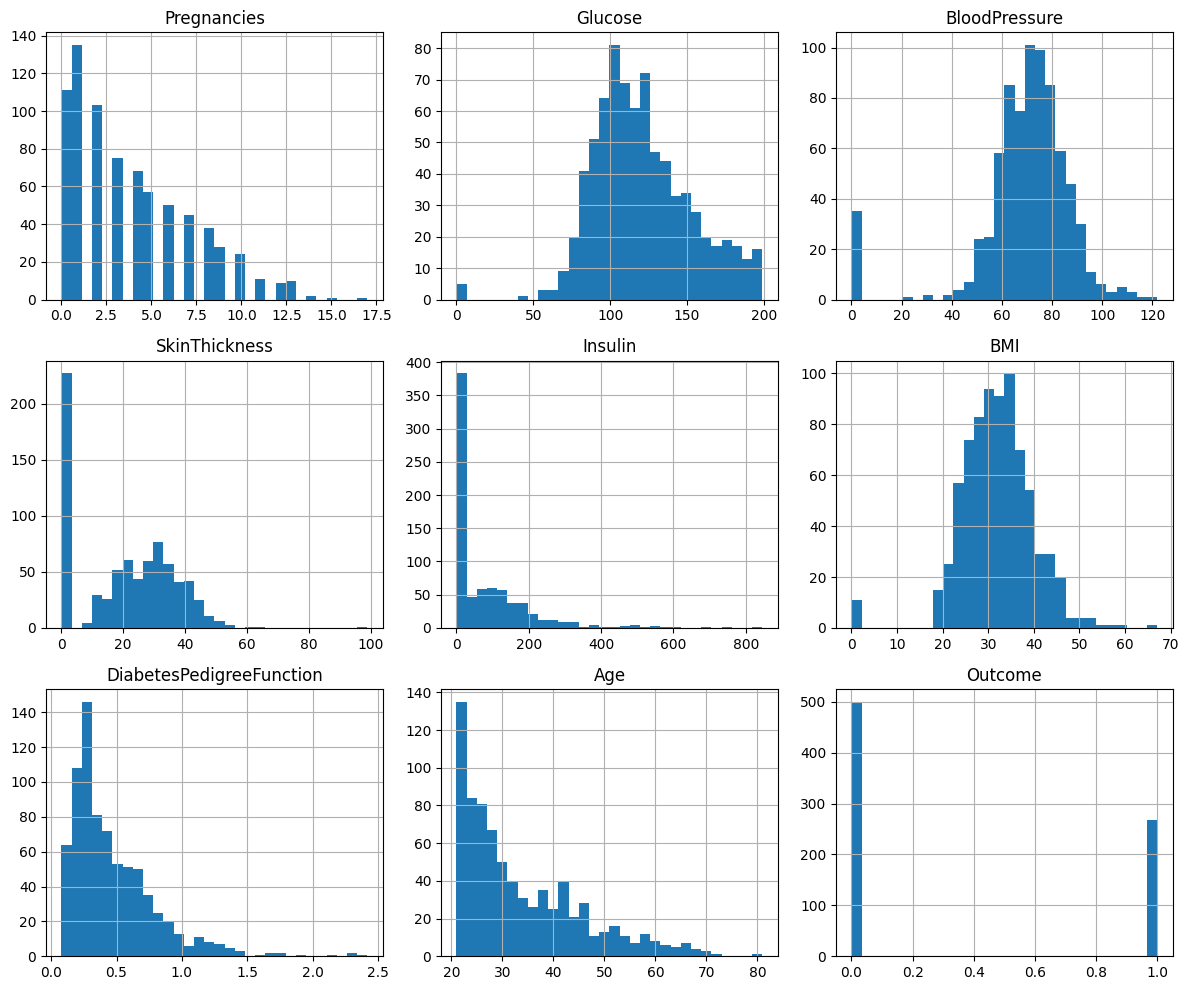

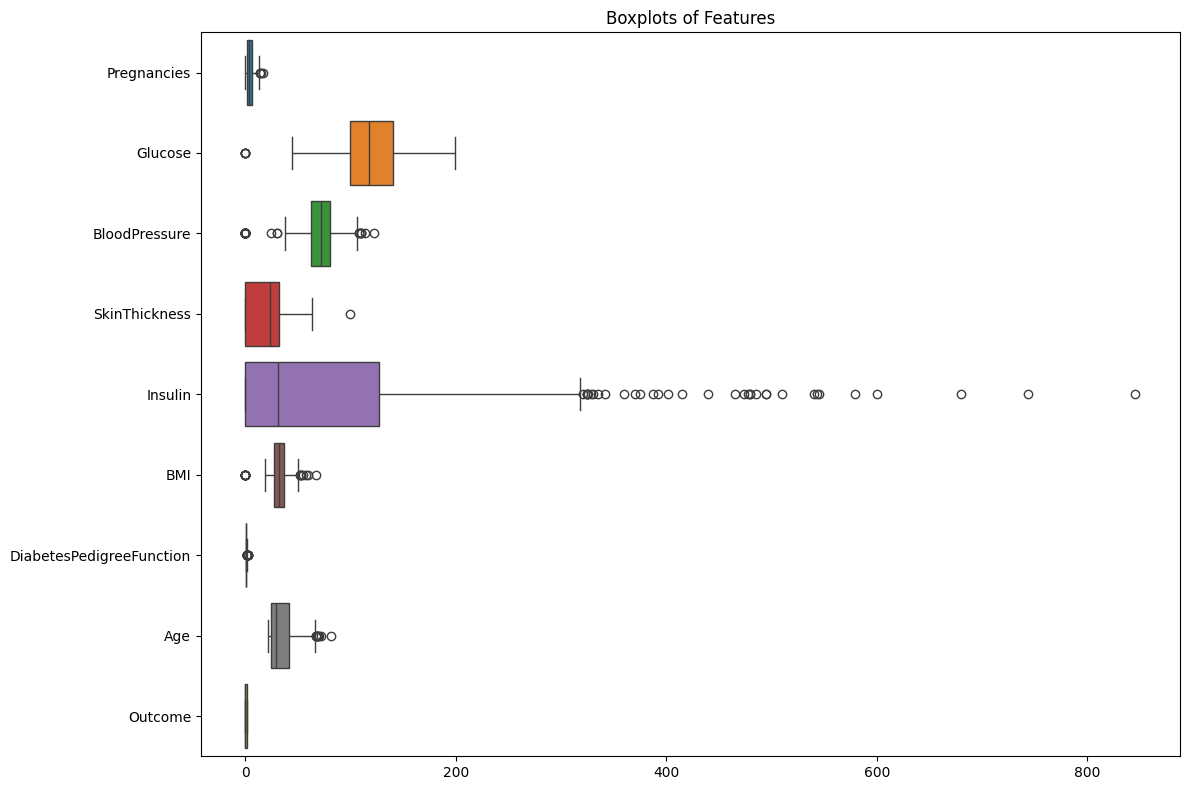

Target balance (Outcome):


Outcome
0    500
1    268
Name: count, dtype: int64

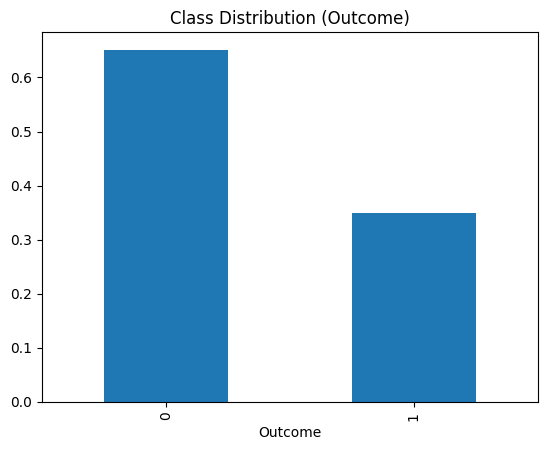

In [23]:
# List columns
print("Columns:", df.columns.tolist())

# Histograms for numeric columns
df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Boxplots for quick outlier scan
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, orient="h")
plt.title("Boxplots of Features")
plt.tight_layout()
plt.show()

# Target balance
print("Target balance (Outcome):")
display(df['Outcome'].value_counts())
df['Outcome'].value_counts(normalize=True).plot(kind='bar', title='Class Distribution (Outcome)')
plt.show()


### 2.2 Handle missing values and clean data

To clean the dataset:
- Replace zeros in the following columns with NaN (not a number):
  - Glucose, BloodPressure, SkinThickness, Insulin, and BMI
    - These features cannot be 0 in real clinical settings, so we treat them as missing data.
- After replacement, we impute the missing values using the median of each column to avoid skewing the dataset
- This ensures the data is biologically meaningful and ready for modeling.


In [24]:
# In the Pima dataset, zeros in these columns are biologically implausible and represent missing values.
cols_with_invalid_zero = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# Count invalid zeros before
zero_counts_before = (df[cols_with_invalid_zero] == 0).sum()
print("Invalid zero counts BEFORE:", zero_counts_before.to_dict())

# Replace zeros with NaN for listed columns
df[cols_with_invalid_zero] = df[cols_with_invalid_zero].replace(0, np.nan)

# Impute NaN with median per column
for c in cols_with_invalid_zero:
    df[c] = df[c].fillna(df[c].median())

# Verify after
zero_counts_after = (df[cols_with_invalid_zero] == 0).sum()
print("Invalid zero counts AFTER (should be 0 now):", zero_counts_after.to_dict())

# Confirm no NaNs remain
print("Any NaNs left?", df.isna().sum().sum())


Invalid zero counts BEFORE: {'Glucose': 5, 'BloodPressure': 35, 'SkinThickness': 227, 'Insulin': 374, 'BMI': 11}
Invalid zero counts AFTER (should be 0 now): {'Glucose': 0, 'BloodPressure': 0, 'SkinThickness': 0, 'Insulin': 0, 'BMI': 0}
Any NaNs left? 0


### 2.3 Feature Selection and Engineering

The dataset is already fully numeric, so no categorical encoding is required.

However, to follow best practices and meet the midterm requirement for feature engineering, one new feature was created:

- **BMI_Category** — groups BMI values into standard medical categories:
  - 0 = Underweight (< 18.5)
  - 1 = Normal (18.5–24.9)
  - 2 = Overweight (25–29.9)
  - 3 = Obese (≥ 30)

This feature may help classification models identify non-linear patterns between BMI and diabetes risk.

**Note:** Although this feature was created, it is not used in the modeling cases (Section 3) because:
- Continuous BMI retains more numeric detail than grouped categories.
- Models like Decision Trees, SVC, and Neural Networks can directly use numeric BMI without needing categories.

BMI_Category could still be useful for:
- Interpreting diabetes risk by weight grouping.
- Future models or visualizations.


In [25]:
# Create a new feature: BMI_Category based on medical classifications

def bmi_category(bmi):
    if bmi < 18.5:
        return 0   # Underweight
    elif bmi < 25:
        return 1   # Normal
    elif bmi < 30:
        return 2   # Overweight
    else:
        return 3   # Obese

df['BMI_Category'] = df['BMI'].apply(bmi_category)

# Preview the new feature
df[['BMI', 'BMI_Category']].head(10)



,BMI,BMI_Category
0,33.6,3
1,26.6,2
2,23.3,1
3,28.1,2
4,43.1,3
5,25.6,2
6,31.0,3
7,35.3,3
8,30.5,3
9,32.3,3


**Reflection 2:**  
What patterns or anomalies do you see? Do any features stand out? 
- The histograms helped me see the overall distribution of each feature and identify unrealistic spikes at zero in insulin, skin thickness, glucose, etc. The boxplots confirmed these as anomalies and also showed outliers in insulin and BMI. This helped justify cleaning and imputing these values in Section 2

What preprocessing steps were necessary to clean and improve the data? 
- I noticed that some features in the dataset (like Glucose, BloodPressure, and BMI) had zeros, which are biologically impossible. These were treated as missing values and replaced using median imputation.

Did you create or modify any features to improve performance?
- To meet feature engineering expectations, I created a new feature called `BMI_Category`, which groups BMI values into underweight, normal, overweight, and obese ranges.
- I decided *not* to use BMI_Category in the main modeling cases because continuous BMI contains more detailed information.
- This engineered feature could still be useful for interpretability or future enhancements.






## Section 3. Feature Selection and Justification


### 3.1 Choose features and target

- **Target Variable (y):** `Outcome` (0 = No Diabetes, 1 = Diabetes)
- **Input Features (X):**  
We will test three different feature cases:

| Case | Features Used           | Description |
|------|--------------------------|-------------|
| Case 1 | `BMI`                    | Body Mass Index (weight / height²) |
| Case 2 | `Glucose`               | Plasma glucose concentration |
| Case 3 | `Glucose`, `BMI`        | Combination of two clinical predictors |

**Selection Justification**  
- `Glucose` is the strongest medical indicator of diabetes.  
- `BMI` measures potential obesity — a known risk factor.  
- Combining both allows the model to learn relationships between weight and glucose levels.


### 3.2 Define X and y


In [26]:
# Case 1: BMI only
X1 = df[['BMI']].dropna()
y1 = df.loc[X1.index, 'Outcome']

# Case 2: Glucose only
X2 = df[['Glucose']].dropna()
y2 = df.loc[X2.index, 'Outcome']

# Case 3: Glucose + BMI
X3 = df[['Glucose', 'BMI']].dropna()
y3 = df.loc[X3.index, 'Outcome']

print("Case 1 Shapes:", X1.shape, y1.shape)
print("Case 2 Shapes:", X2.shape, y2.shape)
print("Case 3 Shapes:", X3.shape, y3.shape)

print("Case 2 shape:", X2.shape, y2.shape)
print("Case 3 shape:", X3.shape, y3.shape)


Case 1 Shapes: (768, 1) (768,)
Case 2 Shapes: (768, 1) (768,)
Case 3 Shapes: (768, 2) (768,)
Case 2 shape: (768, 1) (768,)
Case 3 shape: (768, 2) (768,)


**Reflection 3:**  
Why did you choose these features?
- I chose Glucose and BMI because they are both medically linked to diabetes and showed meaningful variation in the data during exploration.  
  
How might `Glucose` and `BMI` impact predictions or accuracy?  
- Glucose levels are directly related to how the body processes sugar, and high glucose is a key indicator of diabetes. BMI is a measure of body fat, and higher BMI is often associated with insulin resistance and greater risk of developing diabetes.


## Section 4. Train a Model (Classification: Decision Tree)


### 4.1 Split the data into training and test sets using StratifiedShuffleSplit (80/20)

Stratified splitting is used to ensure the proportion of the target classes (0 = No Diabetes, 1 = Diabetes) remains consistent in both training and test sets.



In [27]:


# Case 1: BMI
splitter1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx1, test_idx1 in splitter1.split(X1, y1):
    X1_train = X1.iloc[train_idx1]
    X1_test  = X1.iloc[test_idx1]
    y1_train = y1.iloc[train_idx1]
    y1_test  = y1.iloc[test_idx1]

# Case 2: Glucose
splitter2 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx2, test_idx2 in splitter2.split(X2, y2):
    X2_train = X2.iloc[train_idx2]
    X2_test  = X2.iloc[test_idx2]
    y2_train = y2.iloc[train_idx2]
    y2_test  = y2.iloc[test_idx2]

# Case 3: Glucose + BMI
splitter3 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx3, test_idx3 in splitter3.split(X3, y3):
    X3_train = X3.iloc[train_idx3]
    X3_test  = X3.iloc[test_idx3]
    y3_train = y3.iloc[train_idx3]
    y3_test  = y3.iloc[test_idx3]

print("Case 1 - BMI | Train:", len(X1_train), "| Test:", len(X1_test))
print("Case 2 - Glucose | Train:", len(X2_train), "| Test:", len(X2_test))
print("Case 3 - Glucose + BMI | Train:", len(X3_train), "| Test:", len(X3_test))



Case 1 - BMI | Train: 614 | Test: 154
Case 2 - Glucose | Train: 614 | Test: 154
Case 3 - Glucose + BMI | Train: 614 | Test: 154


### 4.2 Train the Decision Tree model using Scikit-Learn


In [28]:

# Train a separate Decision Tree for each feature case
tree_model1 = DecisionTreeClassifier()
tree_model1.fit(X1_train, y1_train)

tree_model2 = DecisionTreeClassifier()
tree_model2.fit(X2_train, y2_train)

tree_model3 = DecisionTreeClassifier()
tree_model3.fit(X3_train, y3_train)



,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


### 4.3 Evaluate model performance using:
- Accuracy
- Precision
- Recall
- F1-score
- Confusion Matrix (visualized as a heatmap)


Decision Tree — Case 1 (BMI) — TRAINING RESULTS
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       400
           1       0.79      0.53      0.64       214

    accuracy                           0.79       614
   macro avg       0.79      0.73      0.74       614
weighted avg       0.79      0.79      0.77       614

Decision Tree — Case 1 (BMI) — TEST RESULTS
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       100
           1       0.45      0.37      0.41        54

    accuracy                           0.62       154
   macro avg       0.57      0.57      0.57       154
weighted avg       0.61      0.62      0.61       154



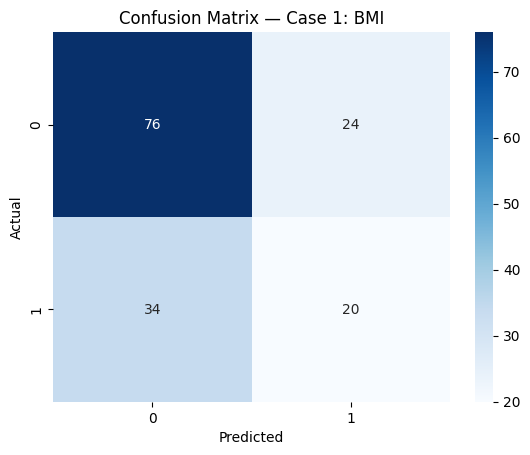

Decision Tree — Case 2 (Glucose) — TRAINING RESULTS
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       400
           1       0.79      0.54      0.64       214

    accuracy                           0.79       614
   macro avg       0.79      0.73      0.75       614
weighted avg       0.79      0.79      0.78       614

Decision Tree — Case 2 (Glucose) — TEST RESULTS
              precision    recall  f1-score   support

           0       0.70      0.86      0.77       100
           1       0.55      0.31      0.40        54

    accuracy                           0.67       154
   macro avg       0.62      0.59      0.59       154
weighted avg       0.65      0.67      0.64       154



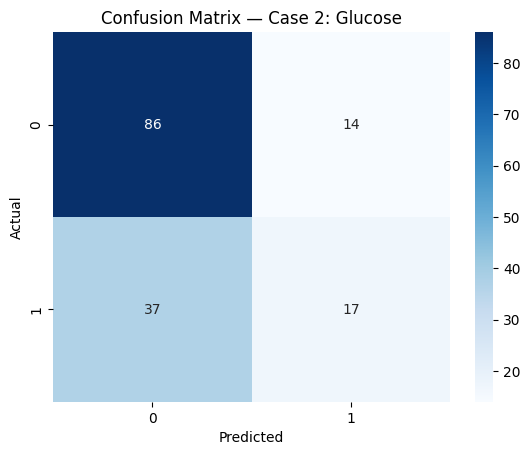

Decision Tree — Case 3 (Glucose + BMI) — TRAINING RESULTS
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       400
           1       1.00      0.98      0.99       214

    accuracy                           0.99       614
   macro avg       0.99      0.99      0.99       614
weighted avg       0.99      0.99      0.99       614

Decision Tree — Case 3 (Glucose + BMI) — TEST RESULTS
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       100
           1       0.59      0.56      0.57        54

    accuracy                           0.71       154
   macro avg       0.68      0.67      0.67       154
weighted avg       0.70      0.71      0.71       154



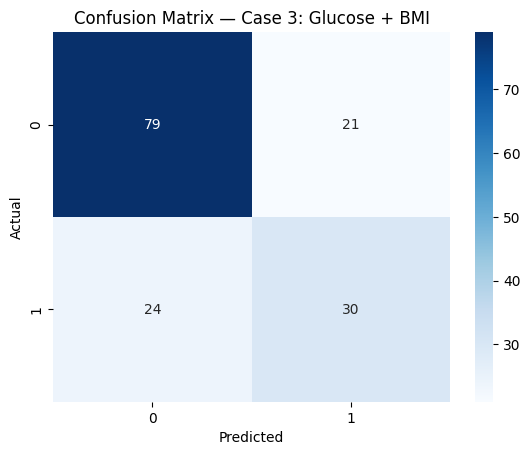

In [29]:

# ------ Case 1: BMI ------
print("Decision Tree — Case 1 (BMI) — TRAINING RESULTS")
print(classification_report(y1_train, tree_model1.predict(X1_train)))

print("Decision Tree — Case 1 (BMI) — TEST RESULTS")
y1_test_pred = tree_model1.predict(X1_test)
print(classification_report(y1_test, y1_test_pred))

sns.heatmap(confusion_matrix(y1_test, y1_test_pred), annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix — Case 1: BMI")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------ Case 2: Glucose ------
print("Decision Tree — Case 2 (Glucose) — TRAINING RESULTS")
print(classification_report(y2_train, tree_model2.predict(X2_train)))

print("Decision Tree — Case 2 (Glucose) — TEST RESULTS")
y2_test_pred = tree_model2.predict(X2_test)
print(classification_report(y2_test, y2_test_pred))

sns.heatmap(confusion_matrix(y2_test, y2_test_pred), annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix — Case 2: Glucose")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------ Case 3: Glucose + BMI ------
print("Decision Tree — Case 3 (Glucose + BMI) — TRAINING RESULTS")
print(classification_report(y3_train, tree_model3.predict(X3_train)))

print("Decision Tree — Case 3 (Glucose + BMI) — TEST RESULTS")
y3_test_pred = tree_model3.predict(X3_test)
print(classification_report(y3_test, y3_test_pred))

sns.heatmap(confusion_matrix(y3_test, y3_test_pred), annot=True, fmt='g', cmap='Blues')
plt.title("Confusion Matrix — Case 3: Glucose + BMI")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Reflection 4:**  
How well did the model perform?
- The Decision Tree performed differently depending on which features were used.
- Case 1 (BMI only) produced the weakest results (Accuracy = 0.62, F1 = 0.41). BMI by itself doesn't separate diabetes vs non-diabetes well.
- Case 2 (Glucose only) showed improvement (Accuracy = 0.67), confirming that glucose is a stronger medical indicator of diabetes.
- Case 3 (Glucose + BMI) performed the best with 71% accuracy. However, there was some overfitting, because accuracy on the training set was 99%, but dropped to 71% on test data.
 
Any surprises in the results?
- The most surprising part was how much better the model performed when combining features, even though only two variables were used.


## Section 5. Improve the Model or Try Alternates


### 5.1 Train an alternative classifier (Support Vector Machine - SVC)

We will follow the same process as the Decision Tree section, using three cases:

- Case 1: Feature = BMI  
- Case 2: Feature = Glucose  
- Case 3: Features = Glucose + BMI  

We will train a Support Vector Classifier (SVC) for each case and evaluate using accuracy, precision, recall, F1-score, and confusion matrix.



Results for SVC on test data (Case 1 - BMI):
              precision    recall  f1-score   support

           0       0.67      0.92      0.77       100
           1       0.50      0.15      0.23        54

    accuracy                           0.65       154
   macro avg       0.58      0.53      0.50       154
weighted avg       0.61      0.65      0.58       154



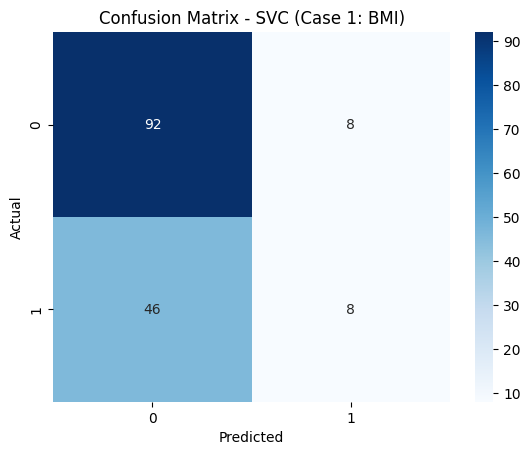

In [30]:
# CASE 1: SVC using BMI
svc_model1 = SVC()
svc_model1.fit(X1_train, y1_train)

# Predictions
y1_svc_pred = svc_model1.predict(X1_test)

# Classification Report
print("Results for SVC on test data (Case 1 - BMI):")
print(classification_report(y1_test, y1_svc_pred))

# Confusion Matrix Heatmap
cm1_svc = confusion_matrix(y1_test, y1_svc_pred)
sns.heatmap(cm1_svc, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - SVC (Case 1: BMI)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Results for SVC on test data (Case 2 - Glucose):
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       100
           1       0.61      0.37      0.46        54

    accuracy                           0.69       154
   macro avg       0.66      0.62      0.62       154
weighted avg       0.68      0.69      0.67       154



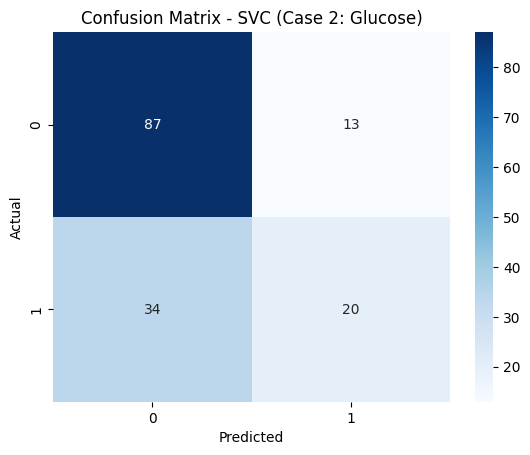

In [31]:
# CASE 2: SVC using Glucose
svc_model2 = SVC()
svc_model2.fit(X2_train, y2_train)

# Predictions
y2_svc_pred = svc_model2.predict(X2_test)

# Classification Report
print("Results for SVC on test data (Case 2 - Glucose):")
print(classification_report(y2_test, y2_svc_pred))

# Confusion Matrix Heatmap
cm2_svc = confusion_matrix(y2_test, y2_svc_pred)
sns.heatmap(cm2_svc, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - SVC (Case 2: Glucose)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Results for SVC on test data (Case 3 - Glucose + BMI):
              precision    recall  f1-score   support

           0       0.72      0.87      0.79       100
           1       0.62      0.39      0.48        54

    accuracy                           0.70       154
   macro avg       0.67      0.63      0.63       154
weighted avg       0.69      0.70      0.68       154



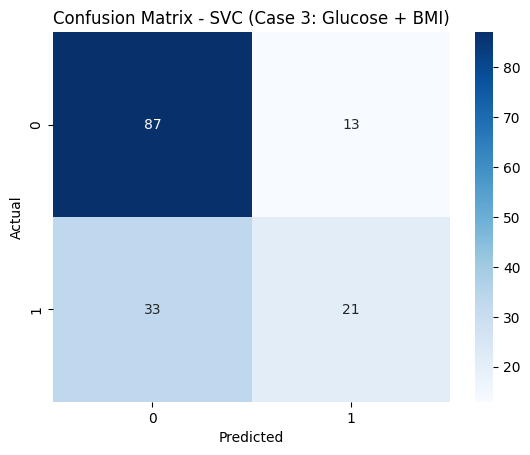

In [32]:
# CASE 3: SVC using Glucose + BMI
svc_model3 = SVC()
svc_model3.fit(X3_train, y3_train)

# Predictions
y3_svc_pred = svc_model3.predict(X3_test)

# Classification Report
print("Results for SVC on test data (Case 3 - Glucose + BMI):")
print(classification_report(y3_test, y3_svc_pred))

# Confusion Matrix Heatmap
cm3_svc = confusion_matrix(y3_test, y3_svc_pred)
sns.heatmap(cm3_svc, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix - SVC (Case 3: Glucose + BMI)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### 5.2 Compare performance of all models across the same metrics

At this point, we have two models trained and tested:
- **Decision Tree Classifier**
- **Support Vector Classifier (SVC)**

Both were evaluated on the same training/test splits using:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix


**Reflection 5:**  
Which model performed better? 
- The Decision Tree Case 3 performed slightly better overall (Accuracy = 0.71) compared to the best SVC version (0.70).
- SVC Case 3 was close, but it struggled more with detecting diabetes cases (Recall = 0.39) compared to Decision Tree (0.56).
  
Why might one classifier be more effective in this specific case?
- Decision Trees seem to handle this dataset better because:
  - They capture non-linear cutoffs.
  - SVC usually performs best after feature scaling and tuning hyperparameters.


## Section 6. Final Thoughts & Insights

**6.1 Summary of Findings:** 

Summary:

- Glucose is the strongest single predictor of diabetes.
- BMI alone is not sufficient to make accurate predictions.
- Combining Glucose + BMI gives the best model accuracy in both Decision Tree and SVC.
- Decision Tree (Case 3) was the highest-performing overall model with 71% accuracy.
- SVC struggled to detect diabetes cases unless glucose was included.
- Data cleaning (replacing zeros) was essential for correct model training.

| Model Type        | Case | Features Used     | Accuracy | Precision (Class 1) | Recall (Class 1) | F1-Score (Class 1) | Notes |
|-------------------|------|-------------------|----------|----------------------|------------------|---------------------|-------|
| Decision Tree     | 1    | BMI               | 0.62     | 0.45                 | 0.37             | 0.41                | Lower performance |
| Decision Tree     | 2    | Glucose           | 0.67     | 0.55                 | 0.31             | 0.40                | Better than BMI   |
| Decision Tree     | 3    | Glucose + BMI     | 0.71     | 0.59                 | 0.56             | 0.57                | Best Decision Tree |
| SVC (RBF Kernel)  | 1    | BMI               | 0.65     | 0.50                 | 0.15             | 0.23                | Struggles with Class 1 |
| SVC (RBF Kernel)  | 2    | Glucose           | 0.69     | 0.61                 | 0.37             | 0.46                | Glucose improves results |
| SVC (RBF Kernel)  | 3    | Glucose + BMI     | 0.70     | 0.62                 | 0.39             | 0.48                | Best SVC case     |



**6.2 Challenges:**   
- Many health measurements had zeros (e.g., Glucose = 0), which are medically impossible so we treated as missing data and replaced with medians.
- Class imbalance: 65% non-diabetic vs 35% diabetic.
- Decision Tree overfitting: Training accuracy reached 99%, while test accuracy was much lower (71%).


**6.3 Next Steps:** 
- I would like to add more features and try scaling.  Later, I would like to try Logistic Regression.


**Reflection 6:**  

This project reinforced what we learned in module 3 while working with the Titanic dataset.  I learned that feature choice definitely matters and even simple models can give valuable insights when evaluated carefully and thoughtfully.  I am excited to learn about regression to try it out on different datasets.